In [1]:
%%capture
!pip install captum

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [3]:
#Data preparation
metabric_X = "https://raw.githubusercontent.com/SalvatoreRa/explanaibleAI/main/tabular_methods/Data/metabric_test.csv"
metabric_y = "https://raw.githubusercontent.com/SalvatoreRa/explanaibleAI/main/tabular_methods/Data/metabric_clin.csv"

X = pd.read_csv(metabric_X)
y = pd.read_csv(metabric_y)['ER_IHC']

# Filter the Series to remove NaN values
nan_indices = y.index[y.isna()]
y = y.dropna()
X = X.drop(nan_indices)

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

In [4]:
#simple neural network for binary classification
class NN_binary_class(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(X.shape[1], 64)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 16)
        self.act2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

model = NN_binary_class()
criterion = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 200
learning_rate = 0.0001




In [5]:

for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for inputs, labels in train_iter:
            # forward pass
            outputs = model(inputs)

            # defining loss


            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
      if epoch % 20 == 0:
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
      running_loss = 0.0

Epoch [1]/[200] running accumulative loss across all batches: 8.826
Epoch [21]/[200] running accumulative loss across all batches: 4.772
Epoch [41]/[200] running accumulative loss across all batches: 3.173
Epoch [61]/[200] running accumulative loss across all batches: 2.638
Epoch [81]/[200] running accumulative loss across all batches: 2.531
Epoch [101]/[200] running accumulative loss across all batches: 2.551
Epoch [121]/[200] running accumulative loss across all batches: 2.488
Epoch [141]/[200] running accumulative loss across all batches: 2.265
Epoch [161]/[200] running accumulative loss across all batches: 2.295
Epoch [181]/[200] running accumulative loss across all batches: 2.311


In [6]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [7]:
# prepare attributions for visualization
feat_imp = pd.DataFrame()


ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
feat_imp["Int Grads"] = ig_attr_test_norm_sum

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)
feat_imp["Int Grads w/SmoothGrad"] = ig_nt_attr_test_norm_sum

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)
feat_imp["DeepLift"] = dl_attr_test_norm_sum

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)
feat_imp["GradientSHAP"] = gs_attr_test_norm_sum

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)
feat_imp["Feature Ablation"]  = fa_attr_test_norm_sum

lin_weight = model.layer1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)
feat_imp["Weights"] = y_axis_lin_weight
feat_imp.index = X.columns.to_list()

<Axes: >

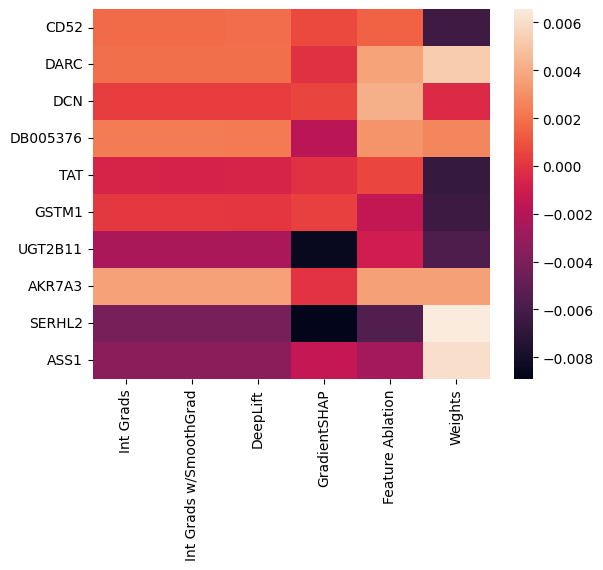

In [8]:
import seaborn as sns

feat_imp_10 = feat_imp.iloc[:10,:]
sns.heatmap(feat_imp_10)


# TGCA

In [9]:
TGCA_X = "https://raw.githubusercontent.com/SalvatoreRa/explanaibleAI/main/tabular_methods/Data/TGCA_test.csv"
TGCA_y = "https://raw.githubusercontent.com/SalvatoreRa/explanaibleAI/main/tabular_methods/Data/TGCA_clin.csv"

X = pd.read_csv(TGCA_X)
y = pd.read_csv(TGCA_y)['primary_diagnosis']

# Filter the Series to remove NaN values
nan_indices = y.index[y.isna()]
y = y.dropna()
X = X.drop(nan_indices)

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)


In [10]:

class NN_binary_class(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(X.shape[1], 64)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 16)
        self.act2 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.output = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

model = NN_binary_class()
criterion = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 200
learning_rate = 0.0001

In [11]:

for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for inputs, labels in train_iter:
            # forward pass
            outputs = model(inputs)

            # defining loss


            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
      if epoch % 20 == 0:
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
      running_loss = 0.0

Epoch [1]/[200] running accumulative loss across all batches: 3.575
Epoch [21]/[200] running accumulative loss across all batches: 2.173
Epoch [41]/[200] running accumulative loss across all batches: 1.695
Epoch [61]/[200] running accumulative loss across all batches: 1.385
Epoch [81]/[200] running accumulative loss across all batches: 1.038
Epoch [101]/[200] running accumulative loss across all batches: 0.919
Epoch [121]/[200] running accumulative loss across all batches: 0.773
Epoch [141]/[200] running accumulative loss across all batches: 0.611
Epoch [161]/[200] running accumulative loss across all batches: 0.540
Epoch [181]/[200] running accumulative loss across all batches: 0.362


In [12]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [13]:
# prepare attributions for visualization
feat_imp = pd.DataFrame()


ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
feat_imp["Int Grads"] = ig_attr_test_norm_sum

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)
feat_imp["Int Grads w/SmoothGrad"] = ig_nt_attr_test_norm_sum

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)
feat_imp["DeepLift"] = dl_attr_test_norm_sum

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)
feat_imp["GradientSHAP"] = gs_attr_test_norm_sum

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)
feat_imp["Feature Ablation"]  = fa_attr_test_norm_sum

lin_weight = model.layer1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)
feat_imp["Weights"] = y_axis_lin_weight
feat_imp.index = X.columns.to_list()

<Axes: >

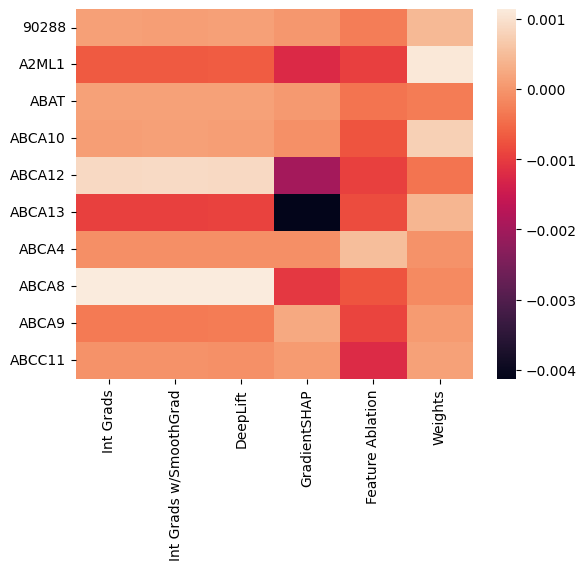

In [14]:
import seaborn as sns

feat_imp_10 = feat_imp.iloc[:10,:]
sns.heatmap(feat_imp_10)


In [20]:
# Compute the attributions of the output with respect to the inputs of the fourth linear layer
lc = LayerConductance(model, model.layer2)

# shape: test_examples x size_hidden
lc_attr_test = lc.attribute(X_test, n_steps=100, attribute_to_layer_input=True)

# weights from forth linear layer
# shape: size_hidden4 x size_hidden3
lin2_weight = model.layer2.weight

y_axis_lc_attr_test = lc_attr_test.mean(0).detach().numpy()
y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)

y_axis_lin2_weight = lin2_weight[0].detach().numpy()
y_axis_lin2_weight = y_axis_lin2_weight / np.linalg.norm(y_axis_lin2_weight, ord=1)

<Axes: >

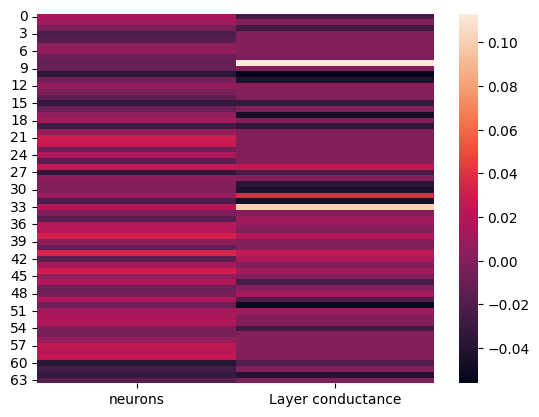

In [21]:
neuro_imp = pd.DataFrame()
neuro_imp['neurons'] = y_axis_lin2_weight
neuro_imp['Layer conductance'] = y_axis_lc_attr_test

sns.heatmap(neuro_imp)